# ResFuse Net

We conceive a different representations for ResNet.

In [1]:
import skimage.io
from classifier.layers import *
from data.image_util import *
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/allen/miniconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
data = load_tiny_imagenet('data/tiny-imagenet-100-A', sub_sample=0.01, subtract_mean=True)

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


In [7]:
# Print out all the keys and values from the data dictionary
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  elif v == None:
    continue
  else:
    print k, type(v), len(v)

X_val <type 'numpy.ndarray'> (5000, 3, 64, 64) float32
class_names <type 'list'> 100
X_train <type 'numpy.ndarray'> (500, 3, 64, 64) float32
y_train <type 'numpy.ndarray'> (500,) int32
X_test <type 'numpy.ndarray'> (5000, 3, 64, 64) float32
y_val <type 'numpy.ndarray'> (5000,) int32
mean_image <type 'numpy.ndarray'> (3, 64, 64) float32


## Visualize Training Data

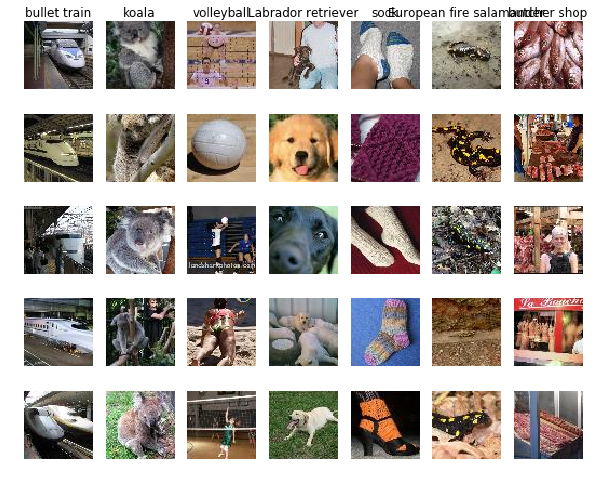

In [8]:
# Visualize some examples of the training data
classes_to_show = 7
examples_per_class = 5

class_idxs = np.random.choice(len(data['class_names']), size=classes_to_show, replace=False)
for i, class_idx in enumerate(class_idxs):
  train_idxs, = np.nonzero(data['y_train'] == class_idx)
  train_idxs = np.random.choice(train_idxs, size=examples_per_class, replace=False)
  for j, train_idx in enumerate(train_idxs):
    img = deprocess_image(data['X_train'][train_idx], data['mean_image'])
    plt.subplot(examples_per_class, classes_to_show, 1 + i + classes_to_show * j)
    if j == 0:
      plt.title(data['class_names'][class_idx][0])
    plt.imshow(img)
    plt.gca().axis('off')

plt.show()

## Batch Normalization in Theano

We are testing if Batch Normalization works in Theano

In [9]:
from classifier.layers import *
from theano.tensor.nnet import bn
import numpy as np
import theano

N, D1, D2, D3 = 200, 50, 60, 3
X = np.asarray(np.random.randn(N, D1), dtype='float32')
W1 = np.asarray(np.random.randn(D1, D2), dtype='float32')
W2 = np.asarray(np.random.randn(D2, D3), dtype='float32')

mean = theano.shared(
            value=np.zeros((D3,), dtype='float32'),
            name='mean',
            borrow=True
        )

var = theano.shared(
            value=np.zeros((D3,), dtype='float32'),
            name='var',
            borrow=True
        )

a = np.maximum(0, X.dot(W1)).dot(W2)

print 'Before batch normalization:'
print '  means: ', a.mean(axis=0)
print '  stds: ', a.std(axis=0)

a_sym = T.matrix('a')
gamma = T.fvector('gamma')
beta = T.fvector('beta')

#mean = T.mean(a_sym, axis=0)
#std = T.var(a_sym, axis=0)

#exp = bn.batch_normalization(a_sym, gamma, beta, mean, std)
exp, mean_var_updates = batch_norm_layer(a_sym, gamma, beta, mean, var, {'mode':'train'})

batchnorm_forward = theano.function([a_sym, gamma, beta], exp, updates=mean_var_updates)

# Means should be close to zero and stds close to one
print 'After batch normalization (gamma=1, beta=0)'
a_norm = batchnorm_forward(a, np.ones(D3, dtype='float32'), np.zeros(D3, dtype='float32'))
print '  mean: ', a_norm.mean(axis=0)
print '  std: ', a_norm.std(axis=0)

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0], dtype='float32')
beta = np.asarray([11.0, 12.0, 13.0], dtype='float32')
a_norm = batchnorm_forward(a, gamma, beta)

print 'After batch normalization (nontrivial gamma, beta)'
print '  means: ', a_norm.mean(axis=0)
print '  stds: ', a_norm.std(axis=0)

Before batch normalization:
  means:  [-29.18686104  14.14393997  -2.01358461]
  stds:  [ 32.91904068  33.97796631  28.91935539]
After batch normalization (gamma=1, beta=0)
  mean:  [  3.01291111e-08  -5.81522137e-09   3.01945890e-09]
  std:  [ 1.          1.          0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.00000003  11.99999999  13.00000001]
  stds:  [ 1.          1.99999999  2.99999998]


## Batch Normalization at Test Time

This part turns out to be slightly more challenging. In Numpy version we store running_mean and running_var in bn_param to keep track, however, in Theano, we must create a shared variable. To update shared variable's values correctly, inside batch_norm layer, we must clone the shared variable, add symbolic computation, and output update rules.

This is the same implementation as in https://gist.github.com/f0k/f1a6bd3c8585c400c190 (Lasagne BatchNormalization)

In [10]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.asarray(np.random.randn(D1, D2), dtype='float32')
W2 = np.asarray(np.random.randn(D2, D3), dtype='float32')

bn_param = {'mode': 'train'}

a_sym = T.matrix('a')
gamma_sym = T.fvector('gamma')
beta_sym = T.fvector('beta')

mean = theano.shared(
            value=np.zeros((D3,), dtype='float32'),
            name='mean',
            borrow=True
        )

var = theano.shared(
            value=np.zeros((D3,), dtype='float32'),
            name='var',
            borrow=True
        )

exp, mean_var_update = batch_norm_layer(a_sym, gamma_sym, beta_sym, mean, var, bn_param)

batchnorm_forward = theano.function([a_sym, gamma_sym, beta_sym], exp, updates=mean_var_update)

for t in xrange(50):
  gamma = np.ones(D3, dtype='float32')
  beta = np.zeros(D3, dtype='float32')
  X = np.asarray(np.random.randn(N, D1), dtype='float32')
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta)

# a_sym2 = T.matrix('a2')
# gamma_sym2 = T.fvector('gamma2')
# beta_sym2 = T.fvector('beta2')

bn_param['mode'] = 'test'
test_exp = batch_norm_layer(a_sym, gamma_sym, beta_sym, mean, var, bn_param)
batchnorm_forward = theano.function([a_sym, gamma_sym, beta_sym], test_exp)

X = np.asarray(np.random.randn(N, D1), dtype='float32')
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm = batchnorm_forward(a, np.ones(D3, dtype='float32'), np.zeros(D3, dtype='float32'))

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print 'After batch normalizatbatchnorm_forward = theano.function([a_sym, gamma, beta], exp)ion (test-time):'
print '  means: ', a_norm.mean(axis=0)
print '  stds: ', a_norm.std(axis=0)

After batch normalizatbatchnorm_forward = theano.function([a_sym, gamma, beta], exp)ion (test-time):
  means:  [-0.00715815 -0.06295193  0.02949273]
  stds:  [ 0.99837264  0.93719599  0.99384844]


## Spatial Batch Normalization in Theano

In [11]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = np.asarray(4 * np.random.randn(N, C, H, W) + 10, dtype='float32')

print 'Before spatial batch normalization:'
print '  Shape: ', x.shape
print '  Means: ', x.mean(axis=(0, 2, 3))
print '  Stds: ', x.std(axis=(0, 2, 3))

x_sym = T.tensor4('x')
gamma_sym = T.fvector('gamma')
beta_sym = T.fvector('beta')

mean = theano.shared(
            value=np.zeros((C,), dtype='float32'),
            name='mean',
            borrow=True
        )

var = theano.shared(
            value=np.zeros((C,), dtype='float32'),
            name='var',
            borrow=True
        )

bn_param = {'mode': 'train'}

exp, mean_var_update = spatial_batch_norm_layer(x_sym, (N, C, H, W), gamma_sym, beta_sym, mean, var, bn_param)

spatial_batchnorm_forward = theano.function([x_sym, gamma_sym, beta_sym], exp, updates=mean_var_update)

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C, dtype='float32'), np.zeros(C, dtype='float32')
out = spatial_batchnorm_forward(x, gamma, beta)
print 'After spatial batch normalization:'
print '  Shape: ', out.shape
print '  Means: ', out.mean(axis=(0, 2, 3))
print '  Stds: ', out.std(axis=(0, 2, 3))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5], dtype='float32'), np.asarray([6, 7, 8], dtype='float32')
out = spatial_batchnorm_forward(x, gamma, beta)
print 'After spatial batch normalization (nontrivial gamma, beta):'
print '  Shape: ', out.shape
print '  Means: ', out.mean(axis=(0, 2, 3))
print '  Stds: ', out.std(axis=(0, 2, 3))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 10.0370121   10.49999428  10.78400612]
  Stds:  [ 3.52684188  3.66751575  3.87755299]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ -1.96043260e-07  -1.21890325e-07   6.45611899e-08]
  Stds:  [ 0.9999996   0.99999963  0.99999967]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [ 5.99999941  6.99999951  8.00000032]
  Stds:  [ 2.99999879  3.99999851  4.99999834]


In [12]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

x_sym = T.tensor4('x')
gamma_sym = T.fvector('gamma')
beta_sym = T.fvector('beta')

mean = theano.shared(
            value=np.zeros((C,), dtype='float32'),
            name='mean',
            borrow=True
        )

var = theano.shared(
            value=np.zeros((C,), dtype='float32'),
            name='var',
            borrow=True
        )

bn_param = {'mode': 'train'}

exp, mean_var_update = spatial_batch_norm_layer(x_sym, (N, C, H, W), gamma_sym, beta_sym, mean, var, bn_param)

spatial_batchnorm_forward = theano.function([x_sym, gamma_sym, beta_sym], exp, updates=mean_var_update)

gamma = np.ones(C, dtype='float32')
beta = np.zeros(C, dtype='float32')

for t in xrange(50):
  x = np.asarray(2.3 * np.random.randn(N, C, H, W) + 13, dtype='float32')
  spatial_batchnorm_forward(x, gamma, beta)

bn_param['mode'] = 'test'

exp = spatial_batch_norm_layer(x_sym, (N, C, H, W), gamma_sym, beta_sym, mean, var, bn_param)

spatial_batchnorm_forward = theano.function([x_sym, gamma_sym, beta_sym], exp)

x = np.asarray(2.3 * np.random.randn(N, C, H, W) + 13, dtype='float32')
a_norm = spatial_batchnorm_forward(x, gamma, beta)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print 'After spatial batch normalization (test-time):'
print '  means: ', a_norm.mean(axis=(0, 2, 3))
print '  stds: ', a_norm.std(axis=(0, 2, 3))

After spatial batch normalization (test-time):
  means:  [ 0.03315812  0.01271803  0.01909106  0.03146296]
  stds:  [ 1.02172341  0.99207073  0.99298042  0.9877698 ]


## Adding BatchNorm to CNN Net

Testing if CNN Net is capable of producing right amount of info from BatchNorm. And if the parameter outputs are correct

In [13]:
from classifier.layers import *
import numpy as np
import theano

net = ConvNet(input_dim=(3,32,32), batch_size=10)
net.add_conv_batch_relu_layer(16, 3, 1, 1, relu_a = 100)
net.add_conv_batch_layer(32, 3, 1, 1)
net.add_affine_softmax(net.prev_depth*net.affine_H*net.affine_W, 2)
net.initialize()

print net.layer_label
print
print net.layer_param
print
print net.params

['conv_batch_relu', 'conv_batch', 'affine_softmax']

[{'relu_a': 100, 'x_shape': (10, 16, 32, 32), 'conv_param': {'stride': 1, 'pad': 1}, 'var': var0, 'bn_param': {'mode': 'train'}, 'mean': mean0}, {'var': var1, 'conv_param': {'stride': 1, 'pad': 1}, 'x_shape': (10, 32, 32, 32), 'bn_param': {'mode': 'train'}, 'mean': mean1}, {}]

{'W1': W1, 'gamma1': gamma1, 'gamma0': gamma0, 'W0': W0, 'b2': b2, 'W2': W2, 'beta1': beta1, 'beta0': beta0}


In [3]:
from classifier.layers import *
import numpy as np
import theano

X = T.tensor4('X')  # data, presented as rasterized images
y = T.ivector('y')

X_train = np.asarray(np.random.randn(10,3,32,32), dtype='float32')
y_train = np.asarray([1,0,0,0,1,1,1,0,0,1], dtype='int32')

# batch_size is normally filled up by Solver
net = ConvNet(input_dim=(3,32,32), batch_size = 10)
net.add_conv_batch_relu_layer(16, 3, 1, 1, relu_a = 100)
net.add_conv_batch_layer(32, 3, 1, 1)
net.add_affine_softmax(net.prev_depth*net.affine_H*net.affine_W, 10)
net.initialize()

loss = net.loss(X, y)  # getting the loss expression

f = theano.function([], loss, givens={X: X_train, y: y_train})
print "Loss for 10 classes is: ", f()

Loss for 10 classes is:  2.31217765808


## Testing Automatic Differentiation

In [4]:
from classifier.layers import *
import numpy as np
import theano

X = T.tensor4('X')  # data, presented as rasterized images
y = T.ivector('y')

X_train = np.asarray(np.random.randn(10,3,32,32), dtype='float32')
y_train = np.asarray([1,0,0,0,1,1,1,0,0,1], dtype='int32')

# batch_size is normally filled up by Solver
net = ConvNet(input_dim=(3,32,32), batch_size = 10)
net.add_conv_relu_layer(16, 3, 1, 1, relu_a = 100)
net.add_conv_relu_layer(32, 3, 1, 1, relu_a = 100)
#net.add_affine_relu_layer(net.prev_depth*net.affine_H*net.affine_W, 200, relu_a=100)
net.add_affine_softmax(net.prev_depth*net.affine_H*net.affine_W, 10)
#net.add_affine_softmax(200, 10)
net.initialize()

loss = net.loss(X, y)  # getting the loss expression
print net.params
dw = T.grad(loss, net.params['W1'])
print loss

{'W1': W1, 'b0': b0, 'W2': W2, 'b2': b2, 'W0': W0, 'b1': b1}
Elemwise{neg,no_inplace}.0


In [64]:
from classifier.layers import *
import numpy as np
import theano

X = T.tensor4('X')  # data, presented as rasterized images
y = T.ivector('y')

X_train = np.asarray(np.random.randn(10,3,32,32), dtype='float32')
y_train = np.asarray([1,0,0,0,1,1,1,0,0,1], dtype='int32')

# batch_size is normally filled up by Solver
net = ConvNet(input_dim=(3,32,32), batch_size = 10)
net.add_conv_batch_relu_layer(16, 3, 1, 1, relu_a = 100)
net.add_conv_batch_layer(32, 3, 1, 1)
net.add_affine_softmax(net.prev_depth*net.affine_H*net.affine_W, 100)
net.initialize()

loss = net.loss(X, y)  # getting the loss expression

print net.params
dw = T.grad(loss, net.params['W1'])
print loss

{'beta1': beta1, 'gamma1': gamma1, 'gamma0': gamma0, 'W0': W0, 'b2': b2, 'b0': b0, 'b1': b1, 'W1': W1, 'beta0': beta0, 'W2': W2}
Elemwise{neg,no_inplace}.0


## Overfit Plain CNN with Solver

We try to overfit a plain CNN with Solver

In [6]:
from classifier.layers import *
from classifier.solver import *
import numpy as np
import theano

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

X = T.tensor4('X')  # data, presented as rasterized images
y = T.ivector('y')

# batch_size needs to be pre-filled
net = ConvNet(input_dim=(3,64,64), batch_size=50, weight_scale=1e-2)
net.add_conv_batch_relu_layer(16, 3, 1, 1, relu_a = 100)
net.add_conv_batch_layer(32, 3, 1, 1)
net.add_affine_softmax(net.prev_depth*net.affine_H*net.affine_W, 100)
net.initialize()

solver = Solver(net, small_data, X, y,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

AttributeError: 'NoneType' object has no attribute 'ndim'

In [96]:
# Compare with a similar model built on Lasagne
# create Theano variables for input and target minibatch

input_var = T.tensor4('X')
target_var = T.ivector('y')

# create a small convolutional neural network
from lasagne.nonlinearities import leaky_rectify, softmax, rectify

network = lasagne.layers.InputLayer((None, 3, 64, 64), input_var)
#conv 1
network = lasagne.layers.Conv2DLayer(network, 16, (3, 3), nonlinearity=rectify)
network = lasagne.layers.batch_norm(network)
#conv 2
network = lasagne.layers.Conv2DLayer(network, 32, (3, 3))
network = lasagne.layers.batch_norm(network)

# softmax
network = lasagne.layers.DenseLayer(network, 100, nonlinearity=softmax,W=lasagne.init.Normal())

prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean() + 1e-4 * lasagne.regularization.regularize_network_params(
    network, lasagne.regularization.l2)

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.001,beta1=0.9, beta2=0.999, epsilon=1e-08)

# compile training function that updates parameters and returns training loss
train_fn = theano.function([input_var, target_var], loss, updates=updates)

In [ ]:
# plot loss history

plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Running BatchNorm with Solver

Solver must be able to not just update parameters, but also specific update rules. Our newly updated Solver can just do that

# ResNet Architecture

## Vanilla ResNet Layer

This is the Vanilla ResNet layer. To keep things simple, downsampling isn't implemented.
We are also following the blueprint of http://torch.ch/blog/2016/02/04/resnets.html. Our ResNet block is No-ReLu, Batch Normalization before addition

![Res Net](https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/resnets_modelvariants.png)


In [ ]:
from classifier.layers import *
import numpy as np
import theano

## Residual-Fusion Layer

(Resfuse Net)

As stated in the original paper, projection instead of identity mapping could perform better. We consider a projection-based mapping amongst layers.

Regular ResNet shows a performance degradation when being used in a 1000-layer construct (shown in the paper), but Leap-Forward ResNet may be able to solve it.

Abstract:

Highway Networks applied a specific projection transformation between input x and F(x)